In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
import re
from scipy.stats import wilcoxon, mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# run semantic similarity 
from glob import glob
files = glob('data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set*.tsv')
# print(files)
for file in files:
    model = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model)
    if model == 'gpt_4':
        continue
    else:
        print(f'python rank_GOterm_LLM_sim_rand.py --input_file {file} --emb_file data/all_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_{model}.tsv')
# run the scripts in terminal 

In [2]:
# open the file 
files= glob('data/GO_term_analysis/model_compare/sim_rank_*.tsv')


In [8]:
files

['data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gemini_pro.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_llama2_70b.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_mixtral_instruct.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_35.tsv']

In [12]:
def bin_scores(df, score_col, prefix):
    # bin scores into no score, low score, medium score, high score
    bins = [-np.inf, 0, 0.79, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.8 to 0.86 is medium score, above 0.86 is high score
    labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

    # Apply the binning to the 'Score' column
    df[f'{prefix} Score Bin'] = pd.cut(df[score_col], bins=bins, labels=labels)

for file in files:
    model = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model)
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    
    score_cols = [col for col in df.columns if col.endswith('Score')]
    for col in score_cols:
        long_prefix = col.split(' ')[0]
        print(long_prefix)
        bin_scores(df, col, long_prefix)
    df.to_csv(file, sep='\t', index=False)


gpt_4
gpt_4_default
gpt_4_50perc_contaminated
gpt_4_100perc_contaminated
mixtral_instruct
mixtral_instruct_default
mixtral_instruct_50perc_contaminated
mixtral_instruct_100perc_contaminated
llama2_70b
llama2_70b_default
llama2_70b_50perc_contaminated
llama2_70b_100perc_contaminated
gemini_pro
gemini_pro_default
gemini_pro_50perc_contaminated
gemini_pro_100perc_contaminated
gpt_35
gpt_3.5_default
gpt_3.5_50perc_contaminated
gpt_3.5_100perc_contaminated


In [13]:
## combine files and sort by semantic similarity score
all_names_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
        
    #rename the column
    df.rename(columns={f'{prefix}_default Name': 'LLM name', f'{prefix}_default Score': 'LLM Score'}, inplace=True)
    df = df.loc[:,['GO', 'Term_Description','LLM name', 'LLM Score','LLM_name_GO_term_sim']]
    df.loc[:,'Model'] = prefix
    all_names_df = pd.concat([all_names_df, df])
    print(all_names_df.shape)
all_names_df.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)

output_df = pd.concat([all_names_df.head(5), all_names_df.tail(5)])
output_df.to_csv('data/GO_term_analysis/model_compare/all_model_top_bottom_5_GO_terms.tsv', sep='\t', index=False)

(100, 6)
(200, 6)
(300, 6)
(400, 6)
(500, 6)


In [3]:
combined_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe

    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']
    # print(df.shape)
    sem_sim = df.loc[:, ['GO', 'LLM_name_GO_term_sim']]
    # sem_sim = df.loc[:, ['GO', 'true_GO_term_sim_percentile']]
    sem_sim['model'] = model_name
    combined_df = pd.concat([combined_df, sem_sim])
combined_df['model'] = combined_df['model'].map({'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5', 'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'})
combined_df.head()

,GO,LLM_name_GO_term_sim,model
0,GO:0014744,0.553494,Gemini Pro
1,GO:0000338,0.364746,Gemini Pro
2,GO:0060696,0.455148,Gemini Pro
3,GO:0019885,0.752696,Gemini Pro
4,GO:0003166,0.618279,Gemini Pro


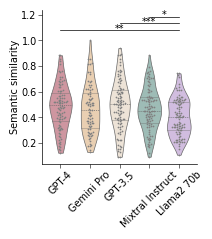

In [4]:
fig, ax = plt.subplots(figsize=(2,2))
order = ['GPT-4', 'Gemini Pro', 'GPT-3.5','Mixtral Instruct', 'Llama2 70b']
# Perform Mann-Whitney U tests
p_values = {}
for i in range(len(order)):
    for j in range(i+1, len(order)):
        model1 = order[i]
        model2 = order[j]
        data1 = combined_df[combined_df['model'] == model1]['LLM_name_GO_term_sim']
        data2 = combined_df[combined_df['model'] == model2]['LLM_name_GO_term_sim']
        stat, p = mannwhitneyu(data1, data2)
        p_values[(model1, model2)] = p
        
#855C75,#D9AF6B,#AF6458,#736F4C,#526A83,#625377,#68855C,#9C9C5E,#A06177,#8C785D,#467378,#7C7C7C
sns.violinplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, inner='quartiles', linewidth=0.5, width=0.8,cut=0, palette=['#d88c9a','#f2d0a9','#f1e3d3','#99c1b9','#d2b7e5'], edgecolor='black')


# Add swarm plot
sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, color='grey', size=1.25, alpha=1)

# sns.violinplot(x='model', y='true_GO_term_sim_percentile', data=combined_df, ax=ax, order=order, inner='quartile', linewidth=0.5, width=0.8,cut=0, palette='Set2')

# Determine the maximum y-value
max_y = max(combined_df['LLM_name_GO_term_sim']) + 0.03  # Adjust the 0.03 if needed

# Offset for each bar to prevent overlap
bar_offset = max_y * 0.05  
i = 0
# Loop through your p-values and add bars for each significant pair
for index, ((model1, model2), p_value) in enumerate(p_values.items()):
    if p_value < 0.05:  # Only plot bars for significant differences
        bar_start = order.index(model1)  # x-coordinate for model1
        bar_end = order.index(model2)    # x-coordinate for model2

        # Adjust y-coordinate for the bar to avoid overlap
        y_coord = max_y + bar_offset + (i * bar_offset)

        # Plot the horizontal line for the significance bar
        ax.plot([bar_start, bar_end], [y_coord, y_coord], color='black', lw=0.5)

        # Add text for significance level
        significance_text = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        ax.text((bar_start + bar_end) / 2, y_coord - 0.01, significance_text, ha='center')
        i += 1


ax.set_ylabel('Semantic similarity')
ax.set_xlabel('')
ax.set_xticklabels(['GPT-4', 'Gemini Pro', 'GPT-3.5','Mixtral Instruct', 'Llama2 70b'],rotation=45, ha='center')
sns.despine()
plt.savefig('figures/model_compare/compare_raw_semantic_similarity_violin.svg', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2607622/356034981.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)


model:  GPT-4 median:  0.49406657499999995
model:  Gemini Pro median:  0.45542836
model:  GPT-3.5 median:  0.502566115
model:  Mixtral Instruct median:  0.45095879
model:  Llama2 70b median:  0.4035816


/tmp/ipykernel_2607622/356034981.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')


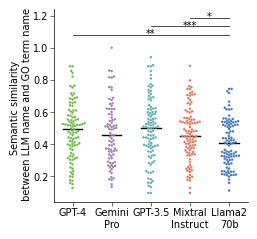

In [5]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
order = ['GPT-4', 'Gemini Pro', 'GPT-3.5','Mixtral Instruct', 'Llama2 70b']
# Perform Mann-Whitney U tests
p_values = {}
for i in range(len(order)):
    for j in range(i+1, len(order)):
        model1 = order[i]
        model2 = order[j]
        data1 = combined_df[combined_df['model'] == model1]['LLM_name_GO_term_sim']
        data2 = combined_df[combined_df['model'] == model2]['LLM_name_GO_term_sim']
        stat, p = mannwhitneyu(data1, data2)
        p_values[(model1, model2)] = p
        
#855C75,#D9AF6B,#AF6458,#736F4C,#526A83,#625377,#68855C,#9C9C5E,#A06177,#8C785D,#467378,#7C7C7C
# sns.violinplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, inner='quartiles', linewidth=0.5, width=0.8,cut=0, palette=['#d88c9a','#f2d0a9','#f1e3d3','#99c1b9','#d2b7e5'], edgecolor='black')

# Add swarm plot
sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)
# add median line 
medians = combined_df.groupby(['model'])['LLM_name_GO_term_sim'].median()
for i in range(len(order)):
    print('model: ', order[i], 'median: ', medians[order[i]])
    ax.plot([i-0.25, i+0.25], [medians[order[i]], medians[order[i]]], lw=1, color='black')


# Determine the maximum y-value
max_y = max(combined_df['LLM_name_GO_term_sim']) + 0.03  # Adjust the 0.03 if needed

# Offset for each bar to prevent overlap
bar_offset = max_y * 0.05  
i = 0
# Loop through your p-values and add bars for each significant pair
for index, ((model1, model2), p_value) in enumerate(p_values.items()):
    if p_value < 0.05:  # Only plot bars for significant differences
        bar_start = order.index(model1)  # x-coordinate for model1
        bar_end = order.index(model2)    # x-coordinate for model2

        # Adjust y-coordinate for the bar to avoid overlap
        y_coord = max_y + bar_offset + (i * bar_offset)

        # Plot the horizontal line for the significance bar
        ax.plot([bar_start, bar_end], [y_coord, y_coord], color='black', lw=0.5)

        # Add text for significance level
        significance_text = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        ax.text((bar_start + bar_end) / 2, y_coord - 0.01, significance_text, ha='center')
        i += 1


ax.set_ylabel('Semantic similarity \n between LLM name and GO term name')
ax.set_xlabel('')
ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')
sns.despine()
plt.savefig('figures/model_compare/compare_raw_semantic_similarity_swamp_only.svg', bbox_inches='tight')
plt.show()


0.28577649501999997 0.28965050999999997 0.10215030574183609


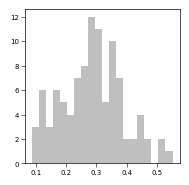

In [7]:
file = files[2]
df = pd.read_csv(file, sep='\t')
# plot random_go_llm_sim
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(df['random_go_llm_sim'], bins=20, color='grey', alpha=0.5, label='random_go_llm_sim')
print(df['random_go_llm_sim'].mean(), df['random_go_llm_sim'].median(), df['random_go_llm_sim'].std())

/tmp/ipykernel_2292657/1690437310.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
/tmp/ipykernel_2292657/1690437310.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
/tmp/ipykernel_2292657/1690437310.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
/tmp/ipykernel_2292657/1690437310.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
/tmp/ipykernel_2292657/1690437310.py:44: UserWarning: FixedFormatter should only be used together with Fixed

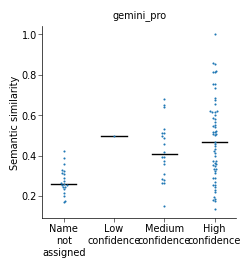

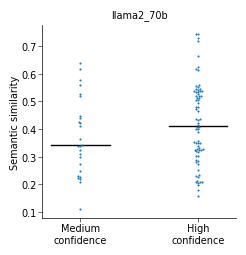

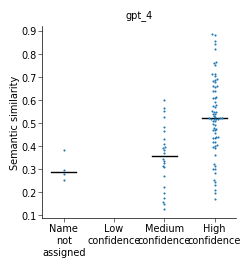

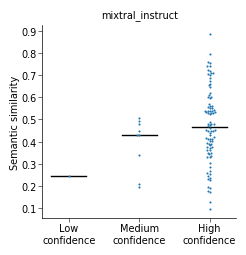

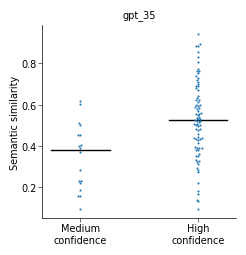

In [11]:
# scatter plot of semantic similarity vs confidence score 
for file in files:
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe

    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
   
    
    # bin scores into no score, low score, medium score, high score
    bins = [-np.inf, 0, 0.79, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.8 to 0.86 is medium score, above 0.86 is high score
    labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

    # Apply the binning to the 'Score' column
    df[f'{prefix}_default Score Bin'] = pd.cut(df[f'{prefix}_default Score'], bins=bins, labels=labels)
    # Perform Mann-Whitney U tests
    p_values = {}
    df_bins = labels 
    for i in range(len(df_bins)):
        for j in range(i+1, len(df_bins)):
            scorebin1 = df_bins[i]
            scorebin2= df_bins[j]
            data1 = df[df[f'{prefix}_default Score Bin'] == scorebin1]['LLM_name_GO_term_sim']
            data2 = df[df[f'{prefix}_default Score Bin'] == scorebin2]['LLM_name_GO_term_sim']
            if len(data1) == 0 or len(data2) == 0:
                continue
                
            stat, p = mannwhitneyu(data1, data2)
            p_values[(scorebin1, scorebin2)] = p
        
    fig, ax = plt.subplots(figsize=(2.5,2.5))
    ax = sns.swarmplot(x=f'{prefix}_default Score Bin', y='LLM_name_GO_term_sim', data=df, ax=ax, order=labels, size=1.5, alpha=1)
    # print(prefix)
    # add median line 
    medians =df.groupby([f'{prefix}_default Score Bin'])['LLM_name_GO_term_sim'].median()
    for i in range(len(df_bins)):
        ax.plot([i-0.25, i+0.25], [medians[df_bins[i]], medians[df_bins[i]]], lw=1, color='black')

    ax.set_xlabel('')
    ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nconfidence', 'High\nconfidence'])
    ax.set_ylabel('Semantic similarity')

    plt.title(model_name)
    sns.despine()

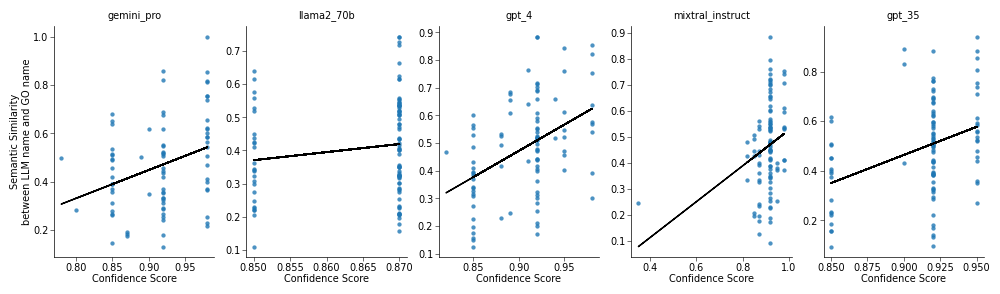

In [8]:
# scatter plot of semantic similarity vs confidence score 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,3))  # Adjust the figure size as needed

for i, file in enumerate(files):
    df = pd.read_csv(file, sep='\t')
    
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe
    df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']

    ax = axs[i]
    ax.scatter(df[f'{prefix}_default Score'], df['LLM_name_GO_term_sim'], alpha=0.8, s=7.5)
    #plot best fit line
    m, b = np.polyfit(df[f'{prefix}_default Score'], df['LLM_name_GO_term_sim'], 1)
    ax.plot(df[f'{prefix}_default Score'], m*df[f'{prefix}_default Score'] + b, color='black', lw=1)
    
    ax.set_title(prefix)
    ax.set_xlabel('Confidence Score')
    
    ax.set_ylabel('Semantic Similarity\nbetween LLM name and GO name' if i == 0 else '')  # Only label y-axis for the first subplot
    
    sns.despine()


    plt.title(model_name)
    sns.despine()

In [9]:
# scatter plot of semantic similarity vs confidence score 
model_list = ['gpt_4','gemini_pro','gpt_35']
combined_df = pd.DataFrame()
for model_name in model_list:
    file = f'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_{model_name}.tsv'
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    # remove unnamed ones
    df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']
    # get the semantic similarity and confidence score
    sem_sim = df.loc[:, ['GO', 'LLM_name_GO_term_sim', f'{prefix}_default Score']]
    sem_sim['model'] = model_name
    #rename score
    sem_sim.rename(columns={f'{prefix}_default Score': 'Confidence score'}, inplace=True)
    combined_df = pd.concat([combined_df, sem_sim])
combined_df['model'] = combined_df['model'].map({'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5'})
# combined_df['model'] = combined_df['model'].map({'gpt_4': 'GPT-4','gpt_35':'GPT-3.5'})
# only keep the GO names where intersects between all models
# intersected_GO = set(combined_df[combined_df['model'] == 'GPT-4']['GO']).intersection(set(combined_df[combined_df['model'] == 'GPT-3.5']['GO']))
# combined_df =combined_df[combined_df['GO'].isin(intersected_GO)]


GPT-3.5 2.2722488208694225 -1.581513652735869
GPT-4 1.8987696602677797 -1.2373470901698975
Gemini Pro 1.1722718335718447 -0.6066417500308271


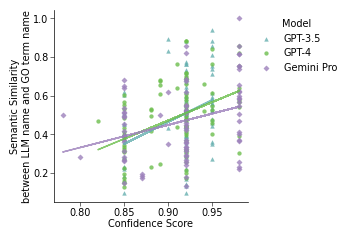

In [26]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

# Define colors for each model. Ensure there are enough colors for all models.
colors = {'GPT-4': '#6CBE4C', 'Gemini Pro': '#9C80BB', 'GPT-3.5': '#65AFAF'}
# colors = {'GPT-4': '#6CBE4C',  'GPT-3.5': '#65AFAF'}
markers = {'GPT-4': 'o', 'Gemini Pro':'D', 'GPT-3.5': '^'}


# Iterate through the DataFrame, plotting each model's data separately
for model, df_group in combined_df.groupby('model'):
    color = colors[model]
    marker = markers[model]
    # Scatter plot for this model #shape of the dot vary with color
    ax.scatter(df_group['Confidence score'], df_group['LLM_name_GO_term_sim'], color=color,  marker= marker, alpha=0.8,s = 7.5,  label=model)
    
    # Calculate and plot best fit line for this model
    m, b = np.polyfit(df_group['Confidence score'], df_group['LLM_name_GO_term_sim'], 1)
    ax.plot(df_group['Confidence score'], m * df_group['Confidence score'] + b, color=color, lw=1, alpha=0.8)
    print(model, m, b)
    #confidence interval
    # x = df_group['Confidence score']
    # y = df_group['LLM_name_GO_term_sim']
    # y_pred = m * x + b
    # resid = y - y_pred
    # mean_resid = resid.mean()
    # std_resid = resid.std()
    # ax.fill_between(x, (m * x + b) - 1.96 * std_resid, (m * x + b) + 1.96 * std_resid, color=color, alpha=0.1)

# Optionally, set labels and title
ax.set_xlabel('Confidence Score')
ax.set_ylabel('Semantic Similarity\nbetween LLM name and GO term name')

ax.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig('figures/model_compare/compare_raw_semantic_similarity_confidence_score.svg', bbox_inches='tight')

plt.show()

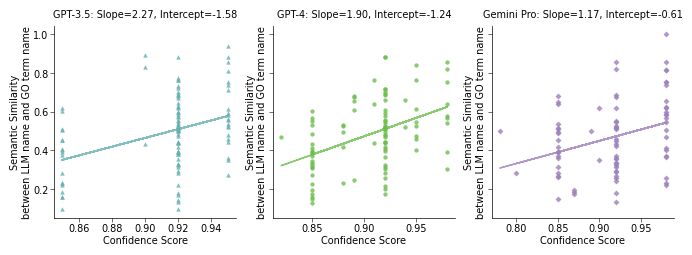

In [11]:


# Define colors for each model. Ensure there are enough colors for all models.
colors = {'GPT-4': '#6CBE4C', 'Gemini Pro': '#9C80BB', 'GPT-3.5': '#65AFAF'}
# colors = {'GPT-4': '#6CBE4C',  'GPT-3.5': '#65AFAF'}
markers = {'GPT-4': 'o', 'Gemini Pro':'D', 'GPT-3.5': '^'}


# Separate plots for each model
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), sharey=True)

for ax, (model, df_group) in zip(axs, combined_df.groupby('model')):
    color = colors[model]
    marker = markers[model]
    ax.scatter(df_group['Confidence score'], df_group['LLM_name_GO_term_sim'], color=color,  marker=marker, alpha=0.8, s=7.5, label=model)
    
    # Calculate and plot best fit line for this model
    m, b = np.polyfit(df_group['Confidence score'], df_group['LLM_name_GO_term_sim'], 1)
    ax.plot(df_group['Confidence score'], m * df_group['Confidence score'] + b, color=color, lw=1, alpha=0.8)
    ax.set_title(f"{model}: Slope={m:.2f}, Intercept={b:.2f}")

    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Semantic Similarity\nbetween LLM name and GO term name')

sns.despine()
plt.savefig('figures/model_compare/compare_raw_semantic_similarity_confidence_score_separate3.svg', bbox_inches='tight')
plt.show()

gemini_pro


/tmp/ipykernel_2135782/1073836665.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])


llama2_70b


/tmp/ipykernel_2135782/1073836665.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])


gpt_4


/tmp/ipykernel_2135782/1073836665.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])


mixtral_instruct
gpt_3.5


/tmp/ipykernel_2135782/1073836665.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])
/tmp/ipykernel_2135782/1073836665.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])


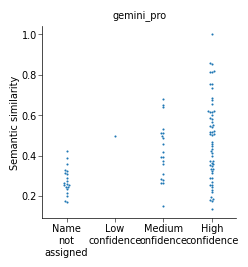

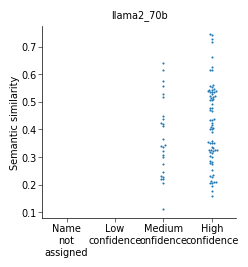

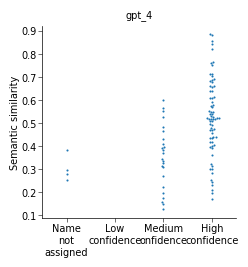

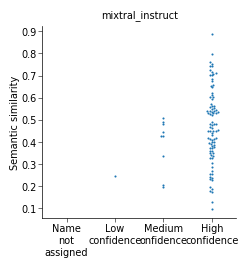

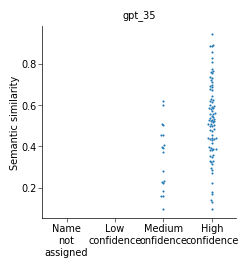

In [29]:
# scatter plot of semantic similarity vs confidence score 
for file in files:
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe

    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    # fig, ax = plt.subplots(figsize=(2,2))
    # sns.swarmplot(x=f'{prefix}_default Score Bin', y='LLM_name_GO_term_sim', data=df, ax=ax, order=labels, size=1.5, alpha=1)
    # print(prefix)
    # plt.xlabel('')
    # plt.ylabel('Semantic similarity')
    # plt.scatter(df[f'{prefix}_default Score'], df['LLM_name_GO_term_sim'],s=3,  alpha=0.5)
    # plt.xlabel('Semantic similarity')   
    # plt.ylabel('Confidence score')
    # plt.title(model_name + 'ALL')
    # sns.despine()
    # # remove system of unrelated proteins
    # df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']
    
    # bin scores into no score, low score, medium score, high score
    bins = [-np.inf, 0, 0.79, 0.86, np.inf] # 0 is no score (name not assigned), between 0 to 0.79 is low score, between 0.8 to 0.86 is medium score, above 0.86 is high score
    labels = ['Name not assigned', 'Low Confidence', 'Medium Confidence', 'High Confidence']  # Define the corresponding labels

    # Apply the binning to the 'Score' column
    df[f'{prefix}_default Score Bin'] = pd.cut(df[f'{prefix}_default Score'], bins=bins, labels=labels)

# plt.scatter(gpt4_df['LLM_name_GO_term_sim'], gpt4_df['gpt_4_default Score'],s=3,  alpha=0.5)
# plt.xlabel('Semantic similarity')   
# plt.ylabel('Confidence score')
# sns.despine()   
# plot swamp of semantic similarity vs confidence score bins

    fig, ax = plt.subplots(figsize=(2.5,2.5))
    ax = sns.swarmplot(x=f'{prefix}_default Score Bin', y='LLM_name_GO_term_sim', data=df, ax=ax, order=labels, size=1.5, alpha=1)
    print(prefix)
    ax.set_xlabel('')
    ax.set_xticklabels(['Name\nnot\nassigned', 'Low\nconfidence', 'Medium\nonfidence', 'High\nconfidence'])
    ax.set_ylabel('Semantic similarity')
    # plt.scatter(df[f'{prefix}_default Score'], df['LLM_name_GO_term_sim'],s=3,  alpha=0.5)
    # plt.xlabel('Semantic similarity')   
    # plt.ylabel('Confidence score')
    plt.title(model_name)
    sns.despine()